In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Get harmonized sentiment index from individual annotations

In [11]:
df = pd.read_csv("Data/review_data_2.csv", index_col=0)

In [12]:
# Quality codes
quality = ['Uncertainty']
# Value codes
value = ['Complexity']

# Select only the rows associated with the selected Quality and Value codes that are linked to Ecosystem Attributes in the 'fuzzy_match_code_lev2' column
df = df.loc[(df['code_lev1'].isin(quality+value))].reset_index()
df['code_lev2'] = df['code_lev2'].replace({'Postive sentiment':'Positive sentiment'})

# Count no. of annotations
annot = df.groupby(['group_folder','attribute','code_lev1'], as_index=False)['document_id'].count().rename(columns={'document_id':'Total annotations'})

# Count no. of papers
papers = df.groupby(['group_folder','attribute','code_lev1'], as_index=False)['document_id'].nunique().rename(columns={'document_id':'Total papers'})

# Group by
df = df.groupby(['group_folder','attribute','code_lev1','code_lev2'], as_index=False)['document_id'].count()
df = df.pivot(index=['group_folder','attribute','code_lev1',], columns='code_lev2', values='document_id').reset_index().fillna(value=0)

# Count no. of annotations
df = pd.merge(df, annot, on=['group_folder','attribute','code_lev1']) # add number of annotations

# Count no. of papers
df = pd.merge(df, papers, on=['group_folder','attribute','code_lev1']) # add number of annotations

# Ratio
df['annotation_paper_ratio'] = df['Total annotations'] / df['Total papers']

# Calculate sentiment index by attribute
df['Sentiment index'] = (df['Negative sentiment']*0 + df['Neutral sentiment']*0.5 + df['Positive sentiment']*1) / df['Total annotations']

# Label for plotting
df['Label'] = df['Sentiment index'].round(decimals=1).astype(str) + \
    ' (' + df['Total annotations'].astype(int).astype(str) + '; ' + \
        df['Total papers'].astype(int).astype(str) +')'

# Sort based on total annotations
df = df.sort_values('attribute')
df.head()

,group_folder,attribute,code_lev1,Negative sentiment,Neutral sentiment,Positive sentiment,Total annotations,Total papers,annotation_paper_ratio,Sentiment index,Label
0,Drone-assisted studies,Fractional veg. cover,Complexity,0.0,1.0,9.0,10,9,1.111111,0.950000,1.0 (10; 9)
1,Drone-assisted studies,Fractional veg. cover,Uncertainty,3.0,2.0,8.0,13,13,1.000000,0.692308,0.7 (13; 13)
17,Field-based studies,Fractional veg. cover,Complexity,2.0,0.0,8.0,10,7,1.428571,0.800000,0.8 (10; 7)
18,Field-based studies,Fractional veg. cover,Uncertainty,4.0,0.0,4.0,8,8,1.000000,0.500000,0.5 (8; 8)
20,Field-based studies,Individuals\n(Indicators/Invasives),Uncertainty,4.0,0.0,1.0,5,5,1.000000,0.200000,0.2 (5; 5)


In [13]:
# Split drone and field dataset

def matrix_with_mask(df, filter):

    df_values = df.pivot(index=['code_lev1'], columns=['attribute', 'group_folder'], values='Sentiment index').T
    df_labels = df.pivot(index=['code_lev1'], columns=['attribute', 'group_folder'], values='Label').T
    df_annot = df.pivot(index=['code_lev1'], columns=['attribute', 'group_folder'], values='Total annotations').T
    
    df_values_old = df_values.copy()
    
    # Categorize values for simplistic plotting
    df_values = df_values.applymap(lambda x: x if pd.isna(x) else (0 if x <= 0.334 else (1 if x >= 0.66 else 0.5)))
    
    # Where there is just one response/annotation, set value to NaN so it does not show in the matrix...
    df_labels = df_labels.where(df_annot>1, np.nan).reset_index() #.set_index(keys='attribute', inplace=False)
    df_values = df_values.where(df_annot>1, np.nan).reset_index() #.set_index(keys='attribute', inplace=False)
        
    # Split
    df_labs_drones = df_labels.loc[df_labels['group_folder']=='Drone-assisted studies'].drop(columns=['group_folder']).set_index('attribute').loc[:,['Uncertainty','Complexity']]
    df_labs_field = df_labels.loc[df_labels['group_folder']=='Field-based studies'].drop(columns=['group_folder']).set_index('attribute').loc[:,['Uncertainty','Complexity']]
    
    df_vals_drones = df_values.loc[df_values['group_folder']=='Drone-assisted studies'].drop(columns=['group_folder']).set_index('attribute').loc[:,['Uncertainty','Complexity']]
    df_vals_field = df_values.loc[df_values['group_folder']=='Field-based studies'].drop(columns=['group_folder']).set_index('attribute').loc[:,['Uncertainty','Complexity']]
    
    for i in np.unique(list(df_vals_field.index) + list(df_vals_drones.index)):
        
        if i not in df_vals_drones.index:
            new_row = pd.Series(index=df_vals_drones.columns, data=np.nan, name=i)
            df_vals_drones = df_vals_drones.append(new_row)
        if i not in df_vals_field.index:
            new_row = pd.Series(index=df_vals_field.columns, data=np.nan, name=i)
            df_vals_field = df_vals_field.append(new_row)
            df_labs_field = df_labs_field.append(new_row)
    
    return(df_labs_field.sort_index(), df_labs_drones.sort_index(), df_vals_field.sort_index(), df_vals_drones.sort_index(), df_values_old)


df_labs_field, df_labs_drones, df_vals_field, df_vals_drones, df_values_old = matrix_with_mask(df, 'Field-based studies')

/tmp/ipykernel_26281/1258267508.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_vals_field = df_vals_field.append(new_row)
/tmp/ipykernel_26281/1258267508.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_labs_field = df_labs_field.append(new_row)


In [14]:
cols = ['Fractional veg. cover', 'Plant func. type\ncomposition', 'Species composition', 
                      'Species richness', 'Individuals\n(Indicators/Invasives)', 
                      'Vegetation structure', 'Topography', 'Productivity\n(Health/Biomass)',
                      'Spatial mosaic']

df_labs_drones = df_labs_drones.reindex(cols)
df_vals_drones = df_vals_drones.reindex(cols)
df_labs_field = df_labs_field.reindex(cols)
df_vals_field = df_vals_field.reindex(cols)

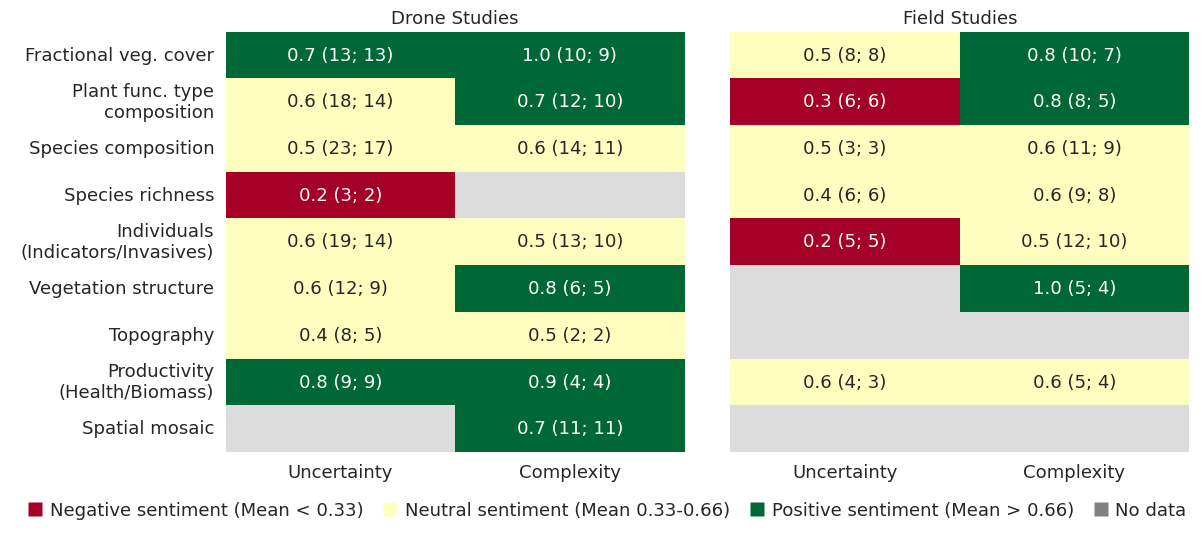

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set Style and context
sns.set_style('white')
sns.set_context("paper", font_scale=1.1)

font_size = 13

# Set up canvas with matplotlib pyplot
fig, axs = plt.subplots(1, 2, figsize=(12, 5.5), sharex=True, sharey=True)

# Create a custom colormap with gray for NaN values
cmap = sns.color_palette("RdYlGn", as_cmap=True)
cmap.set_bad(color='gainsboro', alpha=1.0)

# Create the heatmaps with the custom colormap
heatmap1 = sns.heatmap(data=df_vals_drones, cbar=False, ax=axs[0], annot_kws={'size': font_size},
                       cmap=cmap, annot=df_labs_drones, fmt="s", vmin=0, vmax=1)
heatmap2 = sns.heatmap(data=df_vals_field, cbar=False, ax=axs[1], annot_kws={'size': font_size},
                       cmap=cmap, annot=df_labs_field, fmt="s", vmin=0, vmax=1)

# RGBA colors
rgba_color1 = (0.647, 0.000, 0.149, 1.0)  # For range 0 - 0.33
rgba_color2 = (0.997, 0.999, 0.745, 1.0)  # For range 0.33 - 0.66
rgba_color3 = (0.000, 0.408, 0.216, 1.0)  # For range 0.66 - 1
rgba_gray = (0.5, 0.5, 0.5, 1.0)  # For "no data"

# Create a legend for the color ranges
colors = [rgba_color1, rgba_color2, rgba_color3, rgba_gray]
labels = ['Negative sentiment (Mean < 0.33)', 'Neutral sentiment (Mean 0.33-0.66)', 'Positive sentiment (Mean > 0.66)', "No data"]
# legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markeredgecolor='black',
#                               markerfacecolor=color, markeredgewidth=0.5, markersize=11) for color, label in zip(colors, labels)]
legend_elements = [plt.Line2D([0], [0], marker='s', color='w', label=label, markeredgecolor='none',
                              markerfacecolor=color, markersize=10) for color, label in zip(colors, labels)]


# Place the legend just above the plot
axs[0].legend(handles=legend_elements, loc='lower left',  
              bbox_to_anchor=(-0.49, -0.2), frameon=False, ncol=4,
              columnspacing=0.5,  # Adjust the length of the legend handles
              handletextpad=-0.2, prop = { "size": font_size})  # Adjust the spacing between handle and text)

# Labels and titles
axs[0].set_title('Drone Studies', y=1, fontdict={'fontsize': font_size})
axs[1].set_title("Field Studies", y=1, fontdict={'fontsize': font_size})

# For the first heatmap
axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=font_size)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=font_size)

# For the second heatmap
axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=font_size)

axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_ylabel("")

# Adjust the spacing between subplots
fig.tight_layout()
plt.subplots_adjust(wspace=0.1)  # Change the value to adjust the horizontal spacing
#fig.savefig("Figures/Sentiment_matrix.tif", dpi=1200, bbox_inches='tight')
fig.show()